## References:
1. [Hugginface](https://huggingface.co/vinai/bertweet-large)
2. [Sentiment Analysis with BERT](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=PGnlRWvkY-2c)

In [1]:
import transformers
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import math
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#device = torch.device("cpu")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [2]:
label_names = ['sarcasm', 'irony','satire', 'understatement','overstatement', 'rhetorical_question']

In [3]:
path="./"


TypeI=""
TypeII="TweetPreprocessed."
TypeIII="HalfPreprocessed."
TypeIV="FullyPreprocessed."

path0="TaskB.En.train.Augmented.NotBalanced."
path1="TaskB.En.train.Augmented.Embedding."
path2="TaskB.En.train.Augmented.NotEmbedding."
path3="TaskB.En.train.Augmented.BiasedToLimit."

pathVal="TaskB.En.Basic.Val."
pathTest="TaskB.En.Basic.Test."

In [4]:
chosenPath=path3
ChosenType=TypeII
print(chosenPath)
print(ChosenType)

df_train = pd.read_csv(path + chosenPath + ChosenType + "csv")
df_train.dropna(subset = ["tweet"], inplace=True)
df_val = pd.read_csv(path + pathVal + ChosenType + "csv")
df_val.dropna(subset = ["tweet"], inplace=True)
df_test = pd.read_csv(path + pathTest + ChosenType + "csv")
df_test.dropna(subset = ["tweet"], inplace=True)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

TaskB.En.train.Augmented.BiasedToLimit.
TweetPreprocessed.
(4805, 10)
(522, 10)
(1400, 10)


In [5]:
df_test

,tweet_id,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,NaN,saw a video of someone getting a hug. would LO...,NaN,NaN,0,0,0,0,0,0
1,NaN,"""This Christmas I hope you all either get vacc...",NaN,NaN,0,0,0,0,0,0
2,NaN,It's the alamo,NaN,NaN,0,0,0,0,0,0
3,NaN,"Wind 5 mph E. Barometer 1029.8 hPa, Pressure t...",NaN,NaN,0,0,0,0,0,0
4,NaN,I constantly have loads of the new symptoms bu...,NaN,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1395,NaN,Tempting to renew my membership and vote again...,NaN,NaN,0,0,0,0,0,0
1396,NaN,This week has felt like the longest in history...,NaN,NaN,0,0,0,0,0,0
1397,NaN,Of course it’s raining when I’m due to go out ...,NaN,NaN,0,0,0,0,0,0
1398,NaN,Weigh up a lie before you tell it.,NaN,NaN,0,0,0,0,0,0


180 20 49 1 10 11


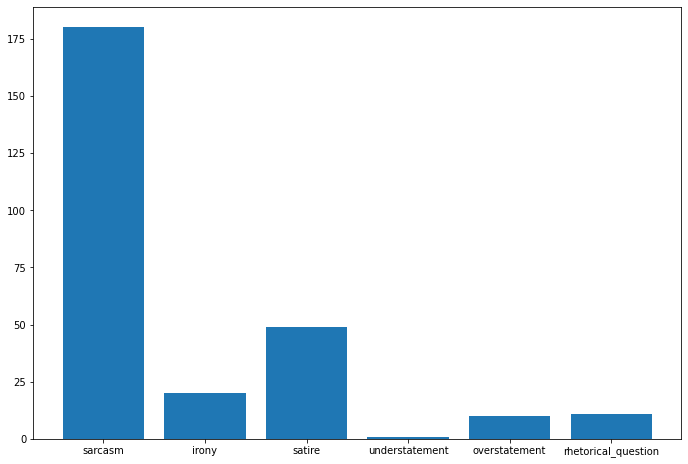

In [6]:
sarcasm=df_test['sarcasm'].sum()
irony=df_test['irony'].sum()
satire=df_test['satire'].sum()
understatement=df_test['understatement'].sum()
overstatement=df_test['overstatement'].sum()
rhetorical_question=df_test['rhetorical_question'].sum()
print(sarcasm,irony,satire,understatement,overstatement,rhetorical_question)

fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
langs = ['sarcasm', 'irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']
students = [sarcasm,irony,satire,understatement,overstatement,rhetorical_question]
ax.bar(langs,students)
plt.show()



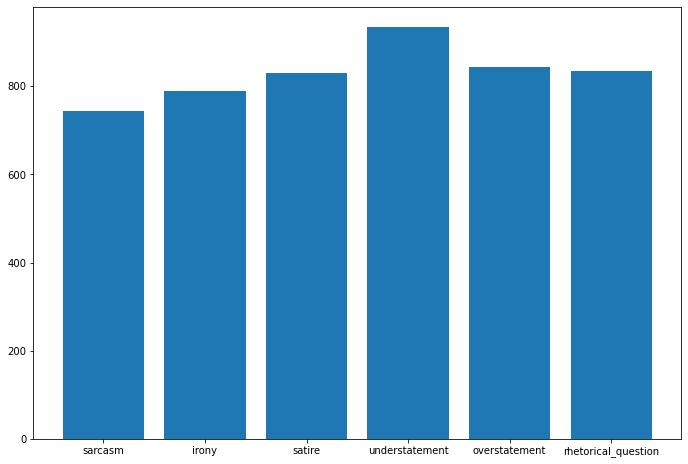

744.0 788.0 829.0 933.0 844.0 835.0


In [7]:
sarcasm=df_train['sarcasm'].sum()
irony=df_train['irony'].sum()
satire=df_train['satire'].sum()
understatement=df_train['understatement'].sum()
overstatement=df_train['overstatement'].sum()
rhetorical_question=df_train['rhetorical_question'].sum()


fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
langs = ['sarcasm', 'irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']
students = [sarcasm,irony,satire,understatement,overstatement,rhetorical_question]
ax.bar(langs,students)
plt.show()
print(sarcasm,irony,satire,understatement,overstatement,rhetorical_question)

In [8]:
PRE_TRAINED_MODEL_NAME = 'vinai/bertweet-large'
bertweet = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use 

In [9]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, normalization=True)

In [10]:
MAX_LEN = 100

In [11]:
class GPTweetDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    
    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [12]:
df_train.shape, df_val.shape, df_test.shape

((4805, 10), (522, 10), (1400, 10))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [13]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  
  sarcasm = df.sarcasm.to_numpy()
  irony = df.irony.to_numpy()
  satire = df.satire.to_numpy()
  understatement = df.understatement.to_numpy()
  overstatement = df.overstatement.to_numpy()
  rhetorical_question = df.rhetorical_question.to_numpy()

  labels = df[["sarcasm", "irony","satire", "understatement","overstatement", "rhetorical_question"]]
  labels = labels.to_numpy()
    
  ds = GPTweetDataset(
    tweets=df.tweet.to_numpy(),
    targets=labels,
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [14]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [15]:
data = next(iter(train_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [16]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16, 6])


In [17]:
class SarcasmClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SarcasmClassifier, self).__init__()
    self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    output = self.out(output)
    return torch.sigmoid(output)

In [18]:
model = SarcasmClassifier(len(label_names))
model = model.to(device)

Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use 

In [19]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 100])
torch.Size([16, 100])


In [20]:
print(input_ids.shape)
print(attention_mask.shape)
F.softmax(model(input_ids, attention_mask), dim=1)

torch.Size([16, 100])
torch.Size([16, 100])


tensor([[0.1751, 0.1546, 0.1566, 0.1590, 0.1766, 0.1781],
        [0.1612, 0.1544, 0.1733, 0.1684, 0.1687, 0.1740],
        [0.1608, 0.1527, 0.1578, 0.1616, 0.1829, 0.1842],
        [0.1567, 0.1540, 0.1762, 0.1646, 0.1798, 0.1687],
        [0.1539, 0.1545, 0.1564, 0.1657, 0.1750, 0.1946],
        [0.1601, 0.1655, 0.1666, 0.1584, 0.1733, 0.1760],
        [0.1661, 0.1583, 0.1615, 0.1635, 0.1689, 0.1818],
        [0.1686, 0.1529, 0.1635, 0.1633, 0.1788, 0.1728],
        [0.1658, 0.1557, 0.1563, 0.1691, 0.1824, 0.1707],
        [0.1705, 0.1459, 0.1689, 0.1642, 0.1697, 0.1809],
        [0.1654, 0.1496, 0.1603, 0.1703, 0.1770, 0.1775],
        [0.1580, 0.1442, 0.1600, 0.1712, 0.1825, 0.1841],
        [0.1680, 0.1565, 0.1651, 0.1665, 0.1691, 0.1748],
        [0.1589, 0.1634, 0.1604, 0.1672, 0.1707, 0.1794],
        [0.1691, 0.1528, 0.1632, 0.1564, 0.1804, 0.1781],
        [0.1670, 0.1540, 0.1614, 0.1641, 0.1709, 0.1826]], device='cuda:1',
       grad_fn=<SoftmaxBackward>)

### Training

In [21]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=6e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.BCELoss().to(device)

In [22]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    
    preds = outputs.round()

    targets = targets.to(torch.float32)

    loss = loss_fn(outputs, targets)

    
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / (n_examples*len(label_names)), np.mean(losses)

In [23]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
    
      preds = outputs.round()

      targets = targets.to(torch.float32)

      loss = loss_fn(outputs, targets)
        
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / (n_examples*len(label_names)), np.mean(losses)

In [24]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
      )

    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
      )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        best_accuracy = val_acc
  

Epoch 1/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'

Train loss 0.2697092326500289 accuracy 0.8950398890045091


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.41269215218948596 accuracy 0.7598978288633461

Epoch 2/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.09347497184832032 accuracy 0.9655913978494622


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.34163933360215387 accuracy 0.8611111111111112

Epoch 3/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.05164408488848875 accuracy 0.9858827610128338


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'

Val   loss 0.408160409692562 accuracy 0.8607918263090677

Epoch 4/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'

Train loss 0.0322492325622774 accuracy 0.9932015261879985


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.40530412982810626 accuracy 0.8764367816091955

Epoch 5/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.023918448542043617 accuracy 0.9956295525494276


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.3893985499938329 accuracy 0.884418901660281

CPU times: user 10min 39s, sys: 2min 40s, total: 13min 19s
Wall time: 13min 24s


## Evaluation

In [25]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0.8329761904761904

In [26]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = outputs.round()
      probs = outputs

      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [27]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'

In [28]:
print(classification_report(y_test, y_pred, target_names=label_names, digits=4))

                     precision    recall  f1-score   support

            sarcasm     0.8883    0.7696    0.8247       434
              irony     0.3217    0.5227    0.3983        88
             satire     0.4286    0.2308    0.3000        13
     understatement     0.0000    0.0000    0.0000         6
      overstatement     0.8889    0.2667    0.4103        30
rhetorical_question     0.6857    0.4706    0.5581        51

          micro avg     0.7281    0.6672    0.6963       622
          macro avg     0.5355    0.3767    0.4152       622
       weighted avg     0.7734    0.6672    0.7036       622
        samples avg     0.7257    0.6906    0.6975       622



/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'

In [30]:
print(classification_report(y_test, y_pred, target_names=label_names, digits=4))

                     precision    recall  f1-score   support

            sarcasm     0.1335    0.8333    0.2301       180
              irony     0.0708    0.7500    0.1293        20
             satire     0.0345    0.0204    0.0256        49
     understatement     0.0000    0.0000    0.0000         1
      overstatement     0.0000    0.0000    0.0000        10
rhetorical_question     0.0610    0.4545    0.1075        11

          micro avg     0.1160    0.6310    0.1960       271
          macro avg     0.0499    0.3430    0.0821       271
       weighted avg     0.1026    0.6310    0.1714       271
        samples avg     0.1175    0.0987    0.1046       271



/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
